In [1]:
import math
from os import path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas
from scipy.io import mmread, mmwrite
from scipy.sparse import hstack, dok_matrix
from rdkit import Chem

In [2]:
chembl_version=31
basepath = "/home/son.ha/FSL_CP_DataPrep/temp"

# cellpainting
path_compound_image_map = path.join(basepath, "cellpainting-index.csv")

# regression
path_regression_idx_assays = path.join(basepath, "chembl{}-regression-assay-index.csv".format(chembl_version))
path_regression_idx_compounds = path.join(basepath, "chembl{}-regression-compound-index.csv".format(chembl_version))
path_regression_values = path.join(basepath, "chembl{}-regression-values.mtx".format(chembl_version))

# classification
path_classification_idx_assays = path.join(basepath, "chembl{}-classification-assay-index.csv".format(chembl_version))
path_classification_idx_compounds = path.join(basepath, "chembl{}-classification-compound-index.csv".format(chembl_version))
path_classification_values = path.join(basepath, "chembl{}-classification-values.mtx".format(chembl_version))

# output
path_result = path.join(basepath, "chembl{}-label-matrix".format(chembl_version))
path_result_asy = path.join(basepath, "chembl{}-labels-assay-index.csv".format(chembl_version))
path_result_cpd = path.join(basepath, "chembl{}-labels-compound-index.csv".format(chembl_version))

In [3]:
idx_cellpainting = pandas.read_csv(path_compound_image_map, sep=",", header=0)
idx_cellpainting = idx_cellpainting.iloc[:,0:3].copy(deep=True)

In [4]:
idx_reg_cpd = pandas.read_csv(path_regression_idx_compounds, sep=",", header=0)
idx_reg_asy = pandas.read_csv(path_regression_idx_assays, sep=",", header=0)
idx_cls_cpd = pandas.read_csv(path_classification_idx_compounds, sep=",", header=0)
idx_cls_asy = pandas.read_csv(path_classification_idx_assays, sep=",", header=0)

In [5]:
reg_val = mmread(path_regression_values).tolil()
cls_val = mmread(path_classification_values).tolil()

In [6]:
clp_inchi = idx_cellpainting["INCHIKEY"].unique().tolist()
clp_inchi_in_chembl_reg = idx_reg_cpd[idx_reg_cpd["INCHIKEY"].isin(clp_inchi)][["INDEX", "INCHIKEY"]]
clp_inchi_in_chembl_cls = idx_cls_cpd[idx_cls_cpd["INCHIKEY"].isin(clp_inchi)][["INDEX", "INCHIKEY"]]
cls_reg_map = clp_inchi_in_chembl_cls.merge(clp_inchi_in_chembl_reg, on="INCHIKEY", how="outer")
cls_reg_map = cls_reg_map.rename(index=str, columns={"INDEX_x": "INDEX_CLS", "INDEX_y": "INDEX_REG"})

In [7]:
print("=== Cellpainting Stats ===")
print("Total Images: {}".format(len(idx_cellpainting)))
print("Unique INCHIKEYS: {}".format(len(clp_inchi)))
print("Compounds in ChEMBL Regression Matrix: {}".format(len(clp_inchi_in_chembl_reg)))
print("Compounds in ChEMBL Classification Matrix: {}".format(len(clp_inchi_in_chembl_cls)))
print("Total Compounds: {}".format(len(cls_reg_map)))

=== Cellpainting Stats ===
Total Images: 126798
Unique INCHIKEYS: 30405
Compounds in ChEMBL Regression Matrix: 10847
Compounds in ChEMBL Classification Matrix: 11178
Total Compounds: 11605


In [8]:
#reg_val = reg_val[clp_inchi_in_chembl_reg["INDEX"].tolist()]

In [9]:
#cls_val = cls_val[clp_inchi_in_chembl_cls["INDEX"].tolist()]

In [10]:
def extract_assays_with_threshold(mtx, assay_idx, pchembl_thresh, min_cpd_per_class=10):
    mtx = mtx.tocsc()
    # threshold
    mtx.data[(mtx.data != 0) & (mtx.data < pchembl_thresh)] = -1
    mtx.data[mtx.data >= pchembl_thresh] = 1
    # min compounds per class
    active = ((mtx == 1).sum(0) >= min_cpd_per_class).tolist()[0]
    inactive = ((mtx == -1).sum(0) >= min_cpd_per_class).tolist()[0]
    both = np.where([a and b for a, b in zip(active, inactive)])[0]
    return mtx[:, both], assay_idx.iloc[both]

def extract_assays_with_min_cpd_per_class(mtx, assay_idx, min_cpd_per_class=10):
    mtx = mtx.tocsc()
    active = ((mtx == 1).sum(0) >= min_cpd_per_class).tolist()[0]
    inactive = ((mtx == -1).sum(0) >= min_cpd_per_class).tolist()[0]
    both = np.where([a and b for a, b in zip(active, inactive)])[0]
    return mtx[:, both], assay_idx.iloc[both]

def remove_empty_compounds(mtx, cpd_idx):    
    empty = set()
    for i, row in enumerate(mtx.tolil().rows):
        if len(row) == 0:
            empty.add(i)
    valid = [i for i in range(0, mtx.shape[0]) if i not in empty]
    return mtx[valid, :], cpd_idx.iloc[valid].reset_index(level=0)

In [11]:
import pandas as pd
lbl_reg5, assays_reg5 = extract_assays_with_threshold(reg_val, idx_reg_asy, 5.5, 10)
lbl_reg6, assays_reg6 = extract_assays_with_threshold(reg_val, idx_reg_asy, 6.5, 10)
lbl_reg7, assays_reg7 = extract_assays_with_threshold(reg_val, idx_reg_asy, 7.5, 10)
lbl_reg = hstack([lbl_reg5, lbl_reg6, lbl_reg7])
#assays_reg = assays_reg5.append(assays_reg6).append(assays_reg7)
assays_reg = pd.concat([assays_reg5, assays_reg6, assays_reg7])
lbl_cls, assays_cls = extract_assays_with_min_cpd_per_class(cls_val, idx_cls_asy, 10)
lbl_cls.data[lbl_cls.data < -1] = -1
lbl_cls.data[lbl_cls.data > 1] = 1
#assay_idx = assays_reg5.append(assays_reg6).append(assays_reg7).append(assays_cls)
assay_idx = pd.concat([assays_reg5, assays_reg6, assays_reg7, assays_cls])

In [12]:
n_row = len(cls_reg_map)
n_col_reg = lbl_reg.shape[1]
n_col_cls = lbl_cls.shape[1]
n_col = n_col_reg + n_col_cls
mat_reg = reg_val.tocsr()
mat_cls = cls_val.tocsr()
mat_all = dok_matrix((n_row, n_col), dtype=np.int8)

## Merge label matrices
for i, row in enumerate(cls_reg_map.itertuples(index=False)):
    idx_reg = row.INDEX_REG
    idx_cls = row.INDEX_CLS
    row_candidate = np.zeros((1, n_col), dtype=np.int8)
    if not math.isnan(idx_reg):
        row_candidate[0, 0:n_col_reg] = lbl_reg[int(idx_reg)].todense()
    if not math.isnan(idx_cls):
        row_candidate[0, n_col_reg:] = lbl_cls[int(idx_cls)].todense()
    mat_all[i] = row_candidate
    print("{}/{}".format(i + 1, len(cls_reg_map)), end="\r")
mat_all, asy_all = extract_assays_with_min_cpd_per_class(mat_all, assay_idx, 10)
mat_all, cls_reg_map = remove_empty_compounds(mat_all, cls_reg_map)
n_row = mat_all.shape[0]

In [13]:
mat_all.shape

(10526, 201)

In [14]:
# produces matrix with inactive and active counts for each assay in the label matrix
def print_assay_stats(mtx, verbose=True):
    mtx_dense = mtx.todense()
    stats = np.zeros((mtx_dense.shape[1], 2), dtype=int)
    if verbose:
        print("Assay\tActive\tInactive")
    for i, col in enumerate(mtx_dense.T):
        uniques = np.unique(col.tolist(), return_counts=True)
        vals = dict(zip(uniques[0], uniques[1]))
        if not -1 in vals:
            vals[-1] = 0
        if not 1 in vals:
            vals[1] = 0
        stats[i] = [vals[-1], vals[1]]
        if verbose:
            print("{}\t{}\t{}".format(asy_all.iloc[i]["ASSAY_ID"], stats[i][1], stats[i][0]))
    return stats, asy_all.iloc[i]["ASSAY_ID"]

In [15]:

print("=== Stats ===")
print("Compounds: {}".format(mat_all.shape[0]))
print("Compound Index: {}".format(cls_reg_map.shape[0]))
print("Assays: {}".format(mat_all.shape[1]))
print("Assay Index: {}".format(asy_all.shape[0]))
print("Percentage Non-zero: {:.4f}".format(mat_all.nnz / (mat_all.shape[0] * mat_all.shape[1])))
print("\n")
_
stats, _ = print_assay_stats(mat_all)

=== Stats ===
Compounds: 10526
Compound Index: 10526
Assays: 201
Assay Index: 201
Percentage Non-zero: 0.0258


Assay	Active	Inactive
737823	16	17
737824	12	10
688422	27	73
688810	16	48
688812	22	16
688816	14	55
688724	10	30
688739	13	85
688759	15	84
688238	21	177
688239	78	105
688157	14	70
688267	32	67
688360	18	15
688620	26	108
688653	16	48
600885	42	76
600886	54	81
688422	13	87
688238	10	188
688239	30	153
600886	11	124
737822	237	595
737826	262	538
737823	429	340
737824	342	498
737825	278	501
752386	135	20
752310	100	60
809005	53	13
1301435	13	15
1301666	36	17
1495242	10	131
1495404	15	125
1495405	127	263
1495415	113	251
737121	14	30
737370	24	15
737357	26	62
737098	28	10
688444	51	27
688279	16	57
809021	24	59
809009	17	118
809014	16	156
809018	21	156
809022	19	154
809023	16	154
809024	18	147
809027	24	140
809031	14	128
809032	21	153
809035	22	150
809039	18	147
809044	25	147
809048	17	141
809051	20	151
809054	21	156
809057	15	156
809059	14	130
809061	22	157
809062	19	156
809073	16	1

Text(0, 0.5, 'Number of assays')

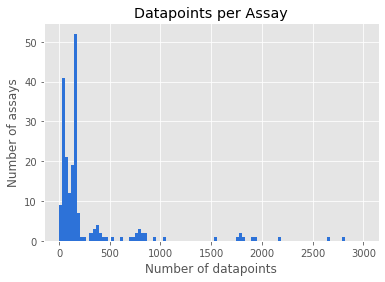

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')

n_datapoints = stats[:,0]+stats[:,1]
plt.gcf().clf()
plt.hist(n_datapoints, bins=100, range=(0,3000), color="#2d72d8")
#plt.xscale("log")
plt.title("Datapoints per Assay")
plt.xlabel("Number of datapoints")
plt.ylabel("Number of assays")
#plt.savefig("datapoints_per_assay.pdf", dpi=300)

In [17]:
mmwrite(path_result, mat_all.tocsc())
asy_all.to_csv(path_result_asy, sep=",", header="ASSAY_ID", index=False)
cls_reg_map["INCHIKEY"].to_csv(path_result_cpd, sep=",", header="INCHIKEY", index=True, index_label="INDEX")